In [50]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

## Setup

In [51]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [52]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run0_bonusmeter_debug'

In [61]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

220 stroke records in the database.
120 clickedObj records in the database.


## Generate group dataframe

In [62]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano

In [63]:
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = h.get_complete_and_valid_games(games,coll,researchers=researchers, tolerate_undefined_worker=True)
complete_games

There was something wrong with this game 2306-68150396-3082-458b-bf35-5683428df704
There was something wrong with this game 2909-8200b9a1-435f-4c08-b71b-04bd71508910
There are 15 complete games in total.


[u'1602-f09f5dc8-0f6a-46ab-9e09-ab12c700e9b5',
 u'2620-5551f382-59eb-4f99-9845-aa356379447c',
 u'1075-935838db-8153-428c-9f1a-2b7c68357508',
 u'6617-8b2133d7-7017-40e0-af39-08ca2b507db2',
 u'7373-d1cf7130-6d9e-4c17-9eaf-f128f3363a9d',
 u'0910-c7b8cea7-d989-4681-8e37-7553dd3bf37a',
 u'1180-2832f7d7-535a-4fb3-acf4-d40972f6d878',
 u'2207-2b879ad0-db06-4fa0-b705-a72bca57eac5',
 u'9920-64d6c563-fe36-41d2-a0ca-286261d1cebb',
 u'9114-90215f67-5c7f-467a-9664-cf43962b5daa',
 u'9553-f10821b2-e94c-4ba3-ab29-51e1d86d848a',
 u'6620-f52e855d-e15a-4e57-86f8-46d8cd83fe33',
 u'2146-edb0dfab-25de-42ab-bba6-0afda275b337',
 u'0475-035859ea-968b-4bef-9d0c-ff12e6e1d940',
 u'6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488']

In [64]:
reload(h)

# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
## TODO: add "Category" to this dataframe
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[]
timedOut=[] # True if sketchers didn't draw anything, False o.w.

_complete_games = complete_games[:2]
for i,g in enumerate(complete_games):
    if g == '6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488':
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                timedOut.append(True)
            else: 
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
                numStrokes.append(lastStrokeNum)
                
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
    
            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488 | 14 of 15: 


In [65]:
## now actually make dataframe
# MAIN DATA
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))
#D = D[D['gameID'] == '1180-2832f7d7-535a-4fb3-acf4-d40972f6d878']
# _D = D[(D.condition=='repeated')]
# _D = _D.sort_values(by=['target','repetition'])
#D=D[D['timedOut'] == False]
D

,gameID,trialNum,condition,target,category,repetition,phase,drawDuration,outcome,response,numStrokes,svgStringLength,svgStringLengthPerStroke,svgStringStd,numCurvesPerSketch,numCurvesPerStroke,timedOut,png
0,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,1,control,knob,chair,0,pre,2.233,False,straight,2,440,220,60,11,5.5,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,2,repeated,woven,chair,0,pre,3.553,True,woven,4,638,159.5,61.1249,16,4,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,3,control,leather,chair,0,pre,1.996,True,leather,1,499,499,0,14,14,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,4,control,inlay,chair,0,pre,0.781,True,inlay,1,318,318,0,10,10,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,5,repeated,sling,chair,0,pre,0.887,True,sling,2,148,74,27,3,1.5,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,6,repeated,squat,chair,0,pre,0.907,True,squat,1,340,340,0,8,8,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,7,repeated,waiting,chair,0,pre,2.241,False,squat,3,290,96.6667,35.9104,7,2.33333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,8,control,straight,chair,0,pre,3.515,True,straight,5,152,30.4,5.31413,5,1,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,9,repeated,woven,chair,1,repeated,2.526,True,woven,3,346,115.333,50.6776,9,3,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488,10,repeated,squat,chair,1,repeated,1.884,True,squat,3,278,92.6667,85.0973,7,2.33333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


## load group data and visualize behavioral measures over time

#### TODO
1. look at individual targets
2. accuracy 
3. repeated vs control
4. urgent: what happened with '1180-2832f7d7-535a-4fb3-acf4-d40972f6d878' and '9114-90215f67-5c7f-467a-9664-cf43962b5daa' -- why are there multiple rows for the same trialNum?

- 1180-2832f7d7-535a-4fb3-acf4-d40972f6d878: trialNum 11 repeated and now trialNum 12, (false bluesport, true bluesdan) - in actual sketches, numRep 1 repeated (without numRep 2) trialNum 39 also repeated 
- 9114-90215f67-5c7f-467a-9664-cf43962b5daa: trialNum 1 repeated and no trialNum 2, they have all the same information except outcome and response, also svgStringStd is 0 for those (false sparrow, true crow) - in actual sketches, numRep 0 repeated (without numRep 1) 
- the bug must be something about being able to click and answer something twice? although why does trialNum remember that things have been done twice? 
- 7373-d1cf7130-6d9e-4c17-9eaf-f128f3363a9d sketch has two "brown"s - also same thing, trialNum 28 repeated (except both outcomes were false because player responded white twice even though it was brown)
- 0910-c7b8cea7-d989-4681-8e37-7553dd3bf37a - viewer guesses correctly with very sparse sketches 

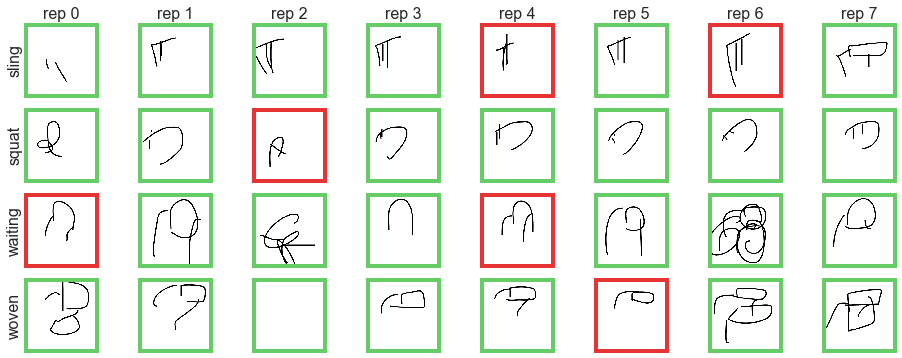

In [66]:
 _valid_gameids = complete_games

for g in _valid_gameids:
    if g =='6958-cc5e6ec4-6b37-4b8f-854a-8f538cfc7488':
        #print 'Printing out sketches from game: ' + g
        trial_types = ['repeated']
        for tt in trial_types:
            _D = D[(D.condition=='repeated') & (D.gameID==g)]
            all_targs = np.unique(_D.target.values) ## use this later to name the file
            _D = _D.sort_values(by=['target','repetition'])
            _i = 1
            textsize=12
            fig = plt.figure(figsize=(16,6))
            for i,_d in _D.iterrows():
                imgData = _d['png']
                filestr = base64.b64decode(imgData)
                fname = 'sketch.png'
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                textsize = 16
                # first plot the target
                im = Image.open(fname)
                p = plt.subplot(4,8,_i)
                plt.imshow(im)
                sns.set_style('white')
                k = p.get_xaxis().set_ticklabels([])
                k = p.get_yaxis().set_ticklabels([])
                k = p.get_xaxis().set_ticks([])
                k = p.get_yaxis().set_ticks([]) 
                outcome = _d['outcome']
                category = _d['category']
                if outcome == 1:
                    sides = ['bottom','top','right','left']
                    for s in sides:
                        p.spines[s].set_color((0.4,0.8,0.4))
                        p.spines[s].set_linewidth(4)                               
                else:
                    sides = ['bottom','top','right','left']
                    for s in sides:
                        p.spines[s].set_color((0.9,0.2,0.2))
                        p.spines[s].set_linewidth(4)    
                if (_i-1 < 8) & (tt in 'repeated'): 
                    plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
                if (_i-1)%8==0:
                    plt.ylabel(_d['target'] ,fontsize=textsize)

                _i  = _i + 1

#             filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
#             if not os.path.exists(os.path.join(sketch_dir,'repeated')):
#                 os.makedirs(os.path.join(sketch_dir,'repeated'))
#             #plt.tight_layout()
#             #plt.savefig(os.path.join(sketch_dir,'repeated',filepath))
#             #plt.close(fig)

In [44]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

##### plot time series during repetition phase 

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


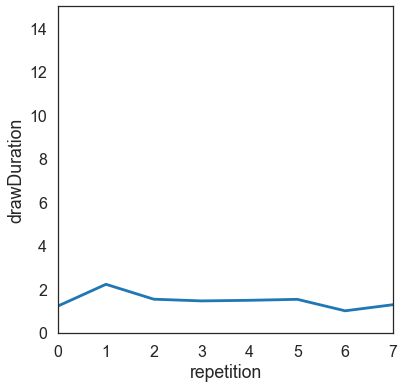

In [49]:
### which thing do you want to plot over time?
dv = 'drawDuration'
D0 = h.plot_across_repeats(D,var=dv,limit=15,save_plot=False,plot_dir=plot_dir)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


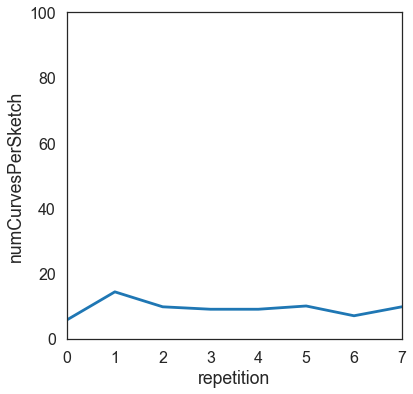

In [42]:
dv = 'numCurvesPerSketch'
D0 = h.plot_across_repeats(D,var=dv,limit=100,save_plot=False,plot_dir=plot_dir)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


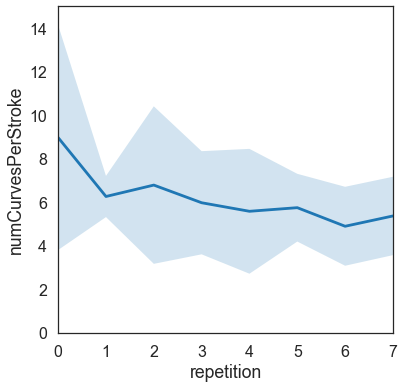

In [23]:
dv = 'numCurvesPerStroke'
D0 = h.plot_across_repeats(D,var=dv,limit=15,save_plot=False,plot_dir=plot_dir)

##### compare conditions in pre and post phases 

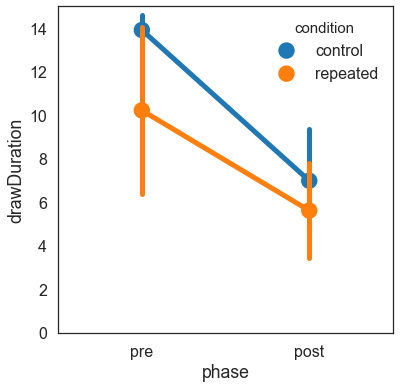

In [11]:
dv = 'drawDuration'
D1 = h.compare_conditions_prepost(D,
                                var=dv,
                                limit=15,
                                save_plot=False,
                                plot_dir=plot_dir)

 ##### visualize how sketches are changing across repetitions

Printing out sketches from game: 2207-2b879ad0-db06-4fa0-b705-a72bca57eac5


IOError: [Errno 63] File name too long: '/Users/megumisano/graphical_conventions/sketches/repeated/2207-2b879ad0-db06-4fa0-b705-a72bca57eac5_0     chair\n1     chair\n2     chair\n3     chair\n4     chair\n5     chair\n6     chair\n7     chair\n8     chair\n9     chair\n10    chair\n11    chair\n12    chair\n13    chair\n14    chair\n15    chair\n16    chair\n17    chair\n18    chair\n19    chair\n20    chair\n21    chair\n22    chair\n23    chair\n24    chair\n25    chair\n26    chair\n27    chair\n28    chair\n29    chair\n      ...  \n50     bird\n51     bird\n52     bird\n53     bird\n54     bird\n55     bird\n56     bird\n57     bird\n58     bird\n59     bird\n60     bird\n61     bird\n62     bird\n63     bird\n64     bird\n65     bird\n66     bird\n67     bird\n68     bird\n69     bird\n70     bird\n71     bird\n72     bird\n73     bird\n74     bird\n75     bird\n76     bird\n77     bird\n78     bird\n79     bird\nName: category, Length: 80, dtype: object.pdf'

##### WORKING AREA: adapt below to render control condition sketches, too

# Miscellaneous

In [ ]:
#seaborn plotting

d = pd.DataFrame()
numReps = 7
variable = 'numStrokes'
# repeated conditions 
criteria_repeated = (D['condition']=='repeated')
repeated = D[criteria_repeated] # get all repeated condition trials 
repeats = list(range(0, numReps)) # number of repeats
repeated_means = []
for rep in repeats:
    mean = ((repeated[(repeated['repetition'] == rep)])[variable]).mean()  # get mean across trials with same repetition number
    repeated_means.append(mean)

# control conditions 
criteria_control = (D['condition']=='control')
control = D[criteria_control] # get all control condition trials 
controls = [0, numReps - 1] # number of controls scaled up to total number of repeats 
control_means= []
for i in [0, 1]: # only 2 controls, but should scale up to numReps 
    mean = ((control[(control['repetition'] == i)])[variable]).mean() # get mean across trials with same repetition number
    control_means.append(mean)

d['numReps'] = repeats
d[variable] = repeated_means
#d['control'] = control_means
facet = sns.lmplot(data=d, x='numReps', y=variable, fit_reg=False)
# add error bars 

In [ ]:
print repeated_strokes.mean(), control_strokes.mean()
print repeated_svgLength.mean(), control_svgLength.mean()
print repeated_svgStd.mean(), control_svgStd.mean()
print repeated_svgLengthPS.mean(), control_svgLengthPS.mean()
print repeated_drawDuration.mean(), control_drawDuration.mean()
print repeated_accuracy.mean(), control_accuracy.mean()

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

In [ ]:
a = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
for rec in a:
    print rec['phase'], rec['condition'],rec['repetition']